In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataaa/Data/bruises wound/bruises (51).jpg
/kaggle/input/dataaa/Data/bruises wound/bruises (13).jpg
/kaggle/input/dataaa/Data/bruises wound/208.jpg
/kaggle/input/dataaa/Data/bruises wound/03d3809b-9b0d-4703-9015-76f2b359ced8.jpg
/kaggle/input/dataaa/Data/bruises wound/212.jpg
/kaggle/input/dataaa/Data/bruises wound/239.jpg
/kaggle/input/dataaa/Data/bruises wound/150.jpg
/kaggle/input/dataaa/Data/bruises wound/149.jpg
/kaggle/input/dataaa/Data/bruises wound/187.jpg
/kaggle/input/dataaa/Data/bruises wound/26d9fe45-a77c-4b0c-8fac-7edd055537f8.jpg
/kaggle/input/dataaa/Data/bruises wound/bruises (50).jpg
/kaggle/input/dataaa/Data/bruises wound/182.jpg
/kaggle/input/dataaa/Data/bruises wound/215.jpg
/kaggle/input/dataaa/Data/bruises wound/185.jpg
/kaggle/input/dataaa/Data/bruises wound/243.jpg
/kaggle/input/dataaa/Data/bruises wound/153.jpg
/kaggle/input/dataaa/Data/bruises wound/189.jpg
/kaggle/input/dataaa/Data/bruises wound/143.jpg
/kaggle/input/dataaa/Data/bruises wound/bru

In [11]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [12]:
# Define paths and load data
def define_paths(data_dir):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis=1)

def split_data(data_dir):
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)
    return train_df, valid_df, test_df


In [14]:
# Image Data Generator
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    color = 'rgb'
    tr_gen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    ts_gen = ImageDataGenerator()

    train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                           color_mode=color, batch_size=batch_size)

    valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                           color_mode=color, batch_size=batch_size)

    test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                          color_mode=color, batch_size=batch_size, shuffle=False)
    return train_gen, valid_gen, test_gen


In [5]:
# Plot images (optional for visualization)
def show_images(gen):
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)
    sample = min(len(labels), 25)

    plt.figure(figsize=(20, 20))
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()


In [15]:
# Plot training performance
def plot_training_performance(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

In [16]:
# Data path
data_dir = '/kaggle/input/dataaa/Data/'

# Load data
train_df, valid_df, test_df = split_data(data_dir)

# Set batch size and generate data generators
batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

Found 1411 validated image filenames belonging to 6 classes.
Found 176 validated image filenames belonging to 6 classes.
Found 177 validated image filenames belonging to 6 classes.


In [37]:
# Define the model architecture
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),                 # Fixed issue here
    Dense(256, activation='relu'),
    Dropout(rate=0.45),
    Dense(class_count, activation='softmax')
])


In [38]:

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['labels']), y=train_df['labels'])
class_weights_dict = dict(enumerate(class_weights))

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=1e-6)


In [39]:
# Train the model
history = model.fit(
    train_gen,
    epochs=40,
    validation_data=valid_gen,
    callbacks=[early_stopping, lr_reduction],
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.3235 - loss: 2.1810 - val_accuracy: 0.4375 - val_loss: 2.6527 - learning_rate: 0.0010
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 556ms/step - accuracy: 0.6818 - loss: 0.9862 - val_accuracy: 0.6761 - val_loss: 1.1613 - learning_rate: 0.0010
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 540ms/step - accuracy: 0.7630 - loss: 0.6352 - val_accuracy: 0.7216 - val_loss: 1.0160 - learning_rate: 0.0010
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 543ms/step - accuracy: 0.8646 - loss: 0.3662 - val_accuracy: 0.8409 - val_loss: 0.4978 - learning_rate: 0.0010
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 546ms/step - accuracy: 0.8942 - loss: 0.3336 - val_accuracy: 0.8523 - val_loss: 0.4763 - learning_rate: 0.0010
Epoch 6/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 530ms/step - accuracy: 0.9236 - loss: 0.2226 - val_accuracy: 0.8580 - val_loss: 0.3957 - learning_rate: 0.0010
Epoch 7/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 536ms/step - accuracy: 0.9451 - loss: 0.17

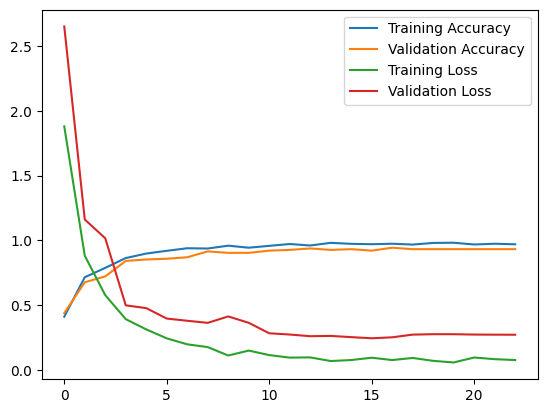

In [40]:
# Plot training performance
plot_training_performance(history)

In [48]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_gen, verbose=0)  # Use the test generator

print(f"Test Accuracy: {test_acc * 100:.2f}%")

Test Accuracy: 92.66%


In [46]:
# Get the final training and validation accuracy
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

# Print the results
print(f"Final Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc * 100:.2f}%")


Final Training Accuracy: 96.95%
Final Validation Accuracy: 93.18%


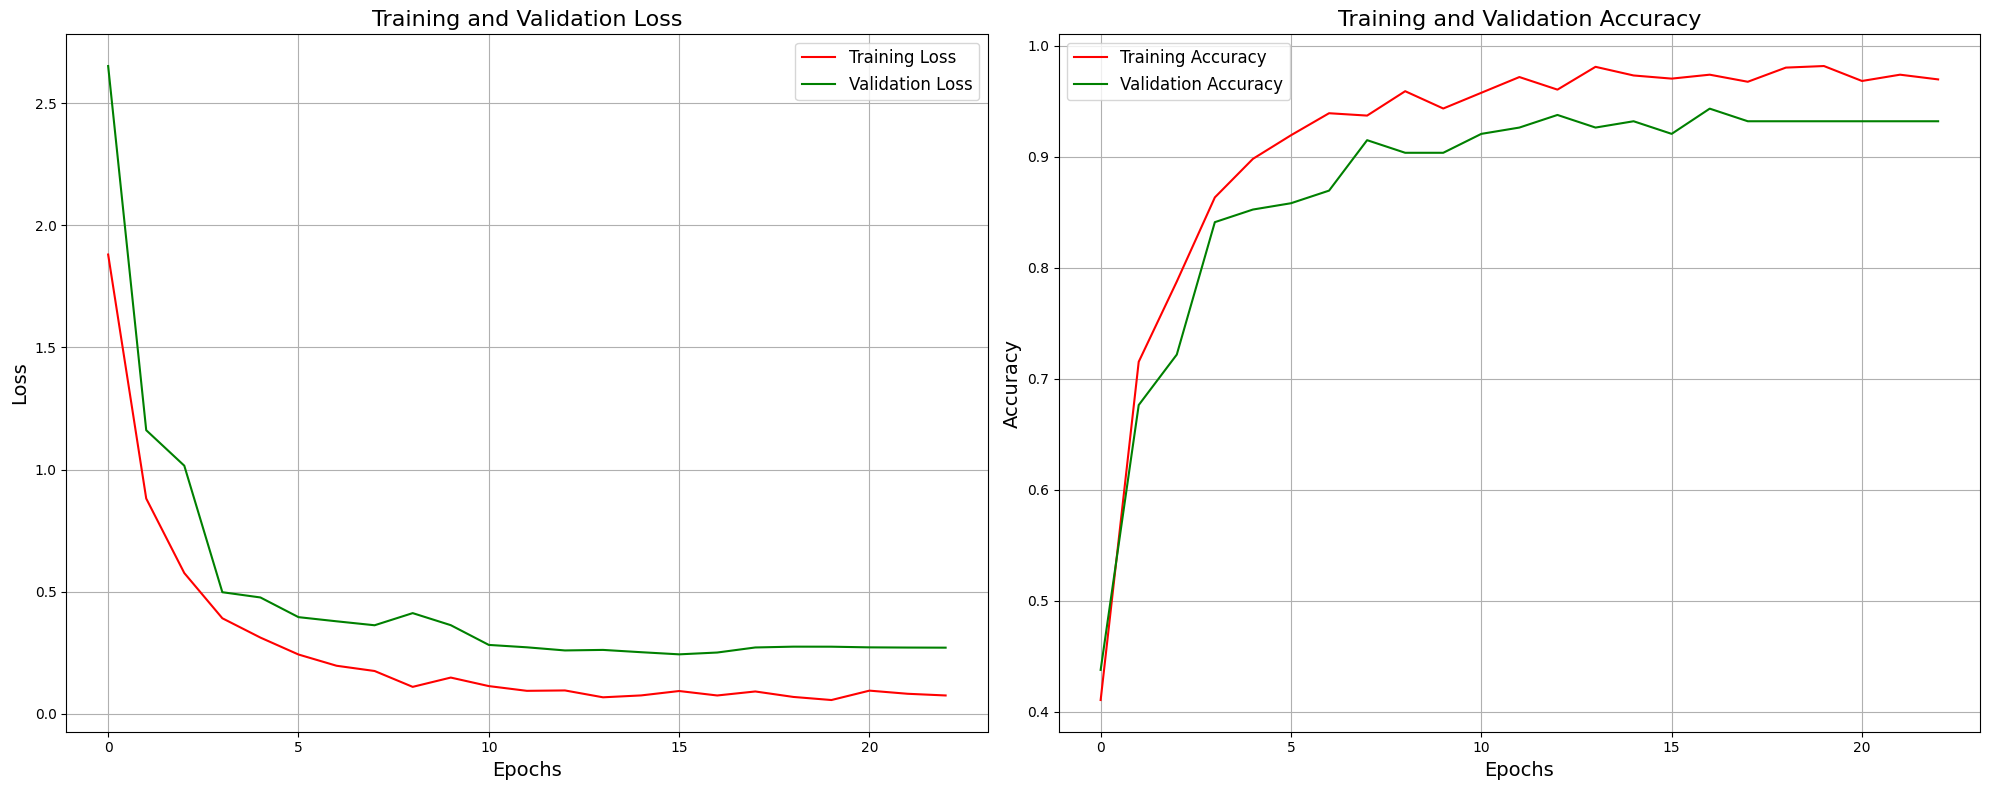

In [47]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(20, 8))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'r-', label='Training Loss')
    plt.plot(history.history['val_loss'], 'g-', label='Validation Loss')
    plt.title('Training and Validation Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], 'r-', label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], 'g-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)


In [45]:
# Save the model
model_save_path = 'model_Type.h5'
model.save(model_save_path)

print(f"Model saved successfully to {model_save_path}")


Model saved successfully to model_Type.h5
